In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from copy import copy as copy

# Vagues scélérates et l'équation non-linéaire de Schrödinger
Nous voulons avec ce projet, obtenier une approximation des ondes scélérates. Celles-ci pouvant être obtenues avec l'amplitude de l'équation de Schrödinger non-linéaire, qui correspond à une fonction d'onde complexe $\psi$(x,t):

$$i\frac{\partial \psi}{\partial t}= -\frac{1}{2}\frac{\partial ^2\psi}{\partial x^2}+ K|\psi|^2\psi$$

Ou $K$ est un paramètre. Le comportement de cette fonction est assez particulier et sera expliqué de suite:

# Partie 1
Nous voulons résoudre l'équation au dessus, avec la condition initiale suivante:

$$\psi (x,0) = 0.5 + 0.01\cos \bigg(\frac{2\pi x}{40}\bigg)$$

Nous irons aussi faire varier le paramètre $K$ de $-1$ à $+1$. Pour ce faire, nous séparer l'équation suivante en un opérateur linéaire et en un non-linéaire (ceci est la méthode Fourier pseudo-spectrale):
$$\begin{split}\frac{\partial \psi}{\partial t} & = \frac{i}{2}\frac{\partial^2\psi}{\partial x^2}- iK|\psi|^2\psi \\
& = \mathscr{L} \psi + \mathscr{N} \psi \end{split}$$
Avec la partie linéaire:
$$\mathscr{L}\psi = \frac{i}{2}\frac{\partial^2\psi}{\partial x^2}$$
et la partie non-linéaire:
$$\mathscr{N} \psi = - iK|\psi|^2\psi $$
Avec l'équation compléte ayant la forme formelle de:

$$\psi (x, t) = \exp^{t(\mathscr{L}+\mathscr{N})}\psi (x, 0)$$

Si nous considérons des petits avancements dans le temps $\Delta t$, nous trouvons une approximation grâce à la formule Baker-Hausdorff:

$$\psi (x, t+\Delta t) = \exp^{\Delta t(\mathscr{L}+\mathscr{N})}\psi (x, t) \approx \exp^{\Delta t\mathscr{L}}\exp^{\Delta t\mathscr{N}}\psi (x, t)$$

Nous pouvons alors avec la transformation de Fourier discréte $\mathscr{F}$ et son inverse $\mathscr{F}^{-1}$:

$$\psi (x, t+\Delta t) = \mathscr{F}^{-1}\Bigg[ \exp^{\frac{-i}{2}\big( \frac{2\pi k}{L}\big)^2\Delta t}\mathscr{F}\Big[ \exp^{-iK|\psi (x,t)|^2\Delta t}\psi (x, t)\Big] \Bigg]$$

Algorithement, la chaîne d'opérations pour la fonction est la suivante:\
\
$1$) Avec $\psi (x, t)$, avance la partie non-linéaire avec $\Delta t$, avec l'update partial

$$g(x, t; \Delta t) = \exp^{-iK|\psi|^2\Delta t}\psi (x, t)$$

$2$) Calculer la transfromation de Fourier de l'update partial

$$\hat{g}_m(t; \Delta t) = \mathscr{F}\big[g(x,t; \Delta t)\big]$$

$3$) Avancer la partie linéaire par $\Delta t$ et calculer la solution complétement mise à jour dans l'espace spectral

$$\hat{\psi}_m(t + \Delta t)=\exp^{\frac{-i}{2}\big( \frac{2\pi k}{L}\big)^2\Delta t}\hat{g}_m(x,t)$$

$4$) Calculer la transformation de Fourier inverse, obtenant la solution mise à jour dans l'espace physique

$$\psi (x, t+\Delta t) = \mathscr{F}^{-1}\big[ \hat{\psi}_m(t+\Delta t)\big]$$

Et puis répéter le cycle dès l'étape $1$ pour le prochain avancement $\Delta t$:

In [5]:
def schrodinger(K, a, Ti = 0, T = 200, N = 1024, L = 40, dt = 0.01):
    temps = np.arange(0, T, dt)
    x = np.linspace(-L/2 + L/N, L/2, N+1)
    m = np.linspace(-N/2, N/2, N+1)
    p = np.zeros((len(x), len(temps)), dtype="complex")
    p[:,0] = 0.5 + 0.01*np.cos(2*np.pi*x/L)

    for i, t in enumerate(temps[:-1]):
        g = np.exp(-1j*K*dt*np.abs(p[:, i])**2)*p[:, i]
        g_m = (1/N)*np.fft.fftshift(np.fft.fft(g))
        p_m = np.exp(dt*(-1j/2)*(2*m*np.pi/L)**2)*g_m
        p[:, i+1] = N*np.fft.ifft(np.fft.ifftshift(p_m))

    if a == 0:
        u, v = np.meshgrid(x, temps)
        c = np.linspace(np.min(np.min(np.abs(p))), np.max(np.max(np.abs(p))), 101)
        plt.contourf(u, v, np.abs(np.transpose(p)), c, cmap = 'jet')

        plt.xlabel('x')
        plt.ylabel('t')
        plt.title("amplitude de psi(x, t) pour K = {}".format(K))
        plt.colorbar()
        plt.show()
        
    if a == 1:
        fig, ax =plt.subplots()
        fig.suptitle("Graphes de l'amplitude de psi(x,t), à des intervalles de temps, avec K = {}".format(K))
        ax.plot(x, np.abs(p[:, int(0/dt)]), c ='k', label = "Amplitude au temps 0")
        ax.plot(x, np.abs(p[:, int(25/dt)]), c ='m', label = "Amplitude au temps 25")
        ax.plot(x, np.abs(p[:, int(50/dt)]), c ='y', label = "Amplitude au temps 50")
        ax.plot(x, np.abs(p[:, int(75/dt)]), c ='g', label = "Amplitude au temps 75")
        ax.plot(x, np.abs(p[:, int(100/dt)]), c ='b', label = "Amplitude au temps 100")
        plt.legend(['t = 0', 't = 25', 't = 50', 't = 75', 't = 100'], loc ='upper left')
        plt.xlabel('x')
        plt.ylabel('amplitude de psi(x,t)')
        
    if a ==2:
        plt.title("Graphe de l'amplitude de psi(x,{}) avec K = -1".format(Ti))
        plt.plot(x, np.abs(p[:, int(Ti/dt)]), c ='k', label = "Amplitude au temps {}".format(Ti))
        plt.xlabel('x')
        plt.ylabel('aplitude de psi(x, {})'.format(Ti))

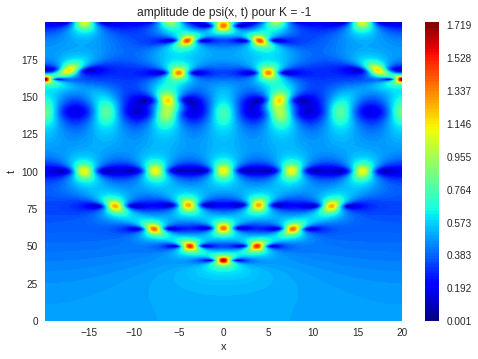

In [4]:
schrodinger(-1, 0)

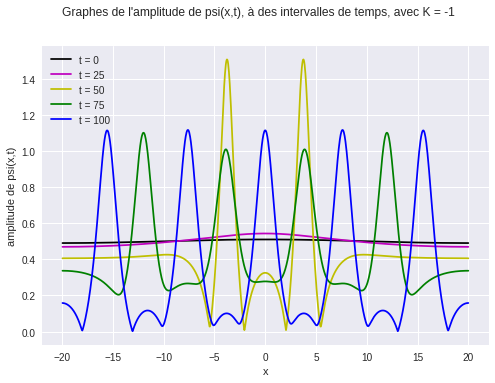

In [6]:
schrodinger(-1, 1)

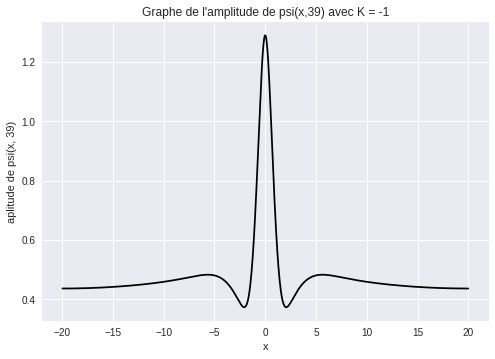

In [7]:
schrodinger(-1, 2, 39)

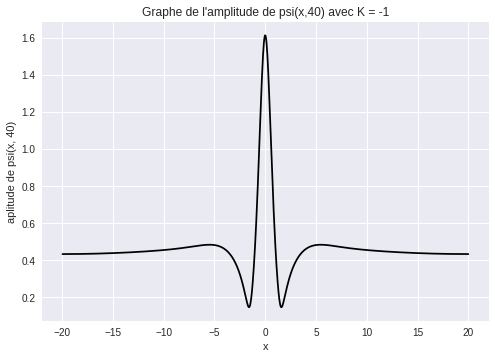

In [8]:
schrodinger(-1, 2, 40)

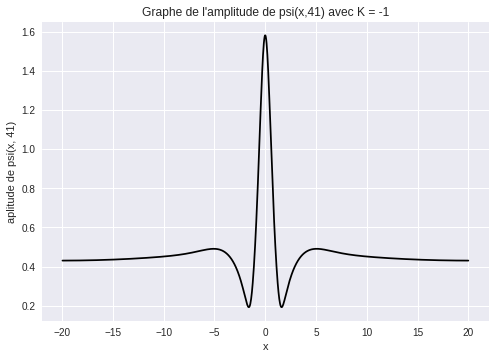

In [9]:
schrodinger(-1, 2, 41)

Nous constatons qu'initialement, l'amplitude psi(x,t) est très faible et varie symétriquement le long de l'axe des x. Cependant aux alentours de t = 40, nous obtenons un maximum pour x = 0, comme nous le voyons dans le troisième graphe. Ensuite, ce pic disparait assez rapidement, seulement pour plus tard, aux alentours de t = 50, réapparaître en deux maxima symétriques par rapport à x = 0. Et ainsi de suite, nous observons une propagation des maxima, montré au deuxième graphe.

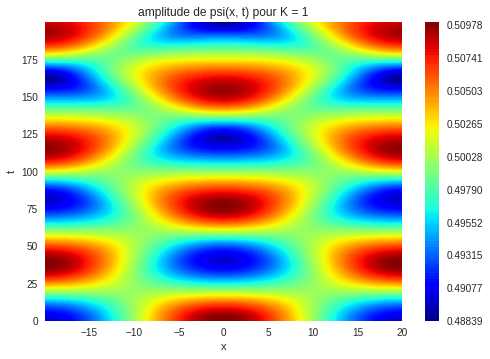

In [10]:
schrodinger(1, 0)

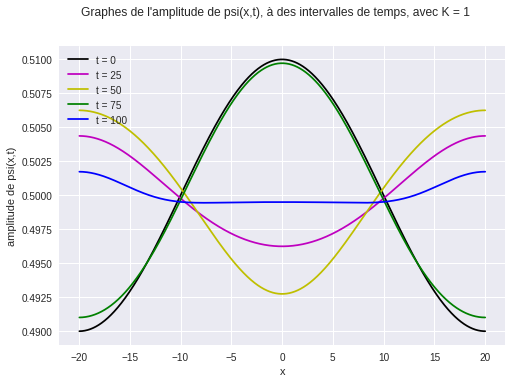

In [11]:
schrodinger(1, 1)

Il est évident qu'ici, il s'agit d'un comportement assez régulier, à une amplitude plus faible que dans la cas précédent. 

Dans le cas ou K < 0, nous avons pu observer des pics à amplitude forte très concentrés en des points précis, symétriques par rapport à x = 0. Nous comprenons pourquoi il a l'appellation de cas 'focusing'.

Dans le cas ou K > 0, nous avons pu cependant observer qu'il n'ya pas de pics localisés mais qu'il s'agit d'un comportement assez global et très régulier. Ceci comme dans le cas au dessus est symétrique par rapport à x = 0, d'ou le nom 'defocusing case'.

# Partie 2
Dans cette partie, nous allons calculer une solution analytique de l'équation non-linéaire de Schrödinger. Celui-ci est appellé le 'Peregrine breather' et est considéré comme un model fondamental des vagues scélérates, avec un domaine non-borné, $x\in (-\infty, +\infty)$ avec $K=-1$:

$$\psi(x,t)=\Big[ 1-\frac{4(1+2it)}{1+4x^2+4t^2}\Big] \exp^{it}$$
\
Afin de pouvoir le calculer nous allons, dans un premier temps le faire sur un domaine $L=6$ et progressivement augmenter $L$ pour trouver de mieux en mieux des bonnes approximations du 'Peregrine breather'. Il faudra aussi choisir un temps et position de départ afin de montrer les phases de amplification et destruction de l'onde. \
Il nous est donné d'avantage, que l'amplitude maximum est achevée en $t=0$ et $x=0$.

In [3]:
def peregrine(L, K = -1, T = 10, N = 1024, dt = 0.01):
    temps = np.arange(-T, T+dt, dt)
    x = np.linspace(-L/2 + L/N, L/2, N+1)
    m = np.linspace(-N/2, N/2, N+1)
    p = np.zeros((len(x), len(temps)), dtype = "complex")
    p2 = copy(p)
    p[:, 0] = np.exp(1j*temps[0])*(1-(4*(1+2j*temps[0]))/(1+4*x**2+4*temps[0]**2))
    p2[:, 0] = copy(p[:, 0])
    
    for i, t in enumerate(temps[:-1]):
        g = np.exp(-1j*K*dt*np.abs(p[:, i])**2)*p[:, i]
        g_m = (1/N)*np.fft.fftshift(np.fft.fft(g))
        p_m = np.exp(dt*(-1j/2)*(2*m*np.pi/L)**2)*g_m
        p[:, i+1] = N*np.fft.ifft(np.fft.ifftshift(p_m))
        p2[:, i+1] = np.exp(1j*t)*(1-(4*(1+2j*t))/(1+4*x**2+4*t**2))
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
    fig.suptitle('Comparaison entre Peregrine exacte et simulée')
    plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.2)
        
    u, v = np.meshgrid(x, temps)
    c1 = np.linspace(np.min(np.min(np.abs(p))),np.max(np.max(np.abs(p))),101)
    c2 = np.linspace(np.min(np.min(np.abs(p2))),np.max(np.max(np.abs(p2))),101)
    a1 = ax1.contourf(u, v, np.abs(np.transpose(p)), c1, cmap = 'jet')
    a2 = ax2.contourf(u, v, np.abs(np.transpose(p2)), c2, cmap = 'jet')
    ax1.set(xlabel = "x", ylabel = "t")
    ax2.set(xlabel = "x", ylabel = "t")
    ax1.set_title("Solution exacte")
    ax2.set_title("Solution simulée")

    fig.colorbar(a1, ax=ax1)
    fig.colorbar(a2, ax=ax2)
    plt.show()
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
        
    ax1.plot(x, np.abs(p2[:, int(T/dt)] - p[:, int(T/dt)]))
    ax1.set_title("Différence temporelle entre simulations (log)")
    ax2.plot(temps, np.abs(p2[int(N/2) -1 , :] - p[int(N/2) -1, :]))
    ax2.set_title("Différence spatialle entre simulations (log)")
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
    
    ax1.plot(x, np.abs(p[:, int(T/dt)]), label = "simulée")
    ax1.plot(x, np.abs(p2[:, int(T/dt)]), label = "théorique")
    ax1.set_title("solutions simulée et théorique")
    ax1.legend()
    ax1.set(xlabel = "x", ylabel = "amplitude")
    
    ax2.plot(temps, np.abs(p[int(N/2) , :]), label = "simulée")
    ax2.plot(temps, np.abs(p2[int(N/2) , :]), label = "théorique")
    ax2.set_title("solutions simulée et théorique")
    ax2.legend()
    ax2.set(xlabel = "t", ylabel = "amplitude")
        

Nous avons, dans un premier temps fait deux calculs: Un pour une solution exacte (graphe de gauche) qui suit la même démarche vu dans la partie $1$ et une (graphe de droite) qui prend uniquement en compte la condition initale qui nous est donnée. 

Nous avons ensuite, des graphes logarithmiques qui nus montrent les différences exactes entre graphes d'un point de vue temporel et puis spatial. 

Finalement, nous avons des graphes qui nous montrent les graphes superposés et nne dépendant que d'un premier temps de la position et ensuite du temps.

Nous irons progressivement augmenter la variable L, afin d'obtenir de meilleurs résultats.

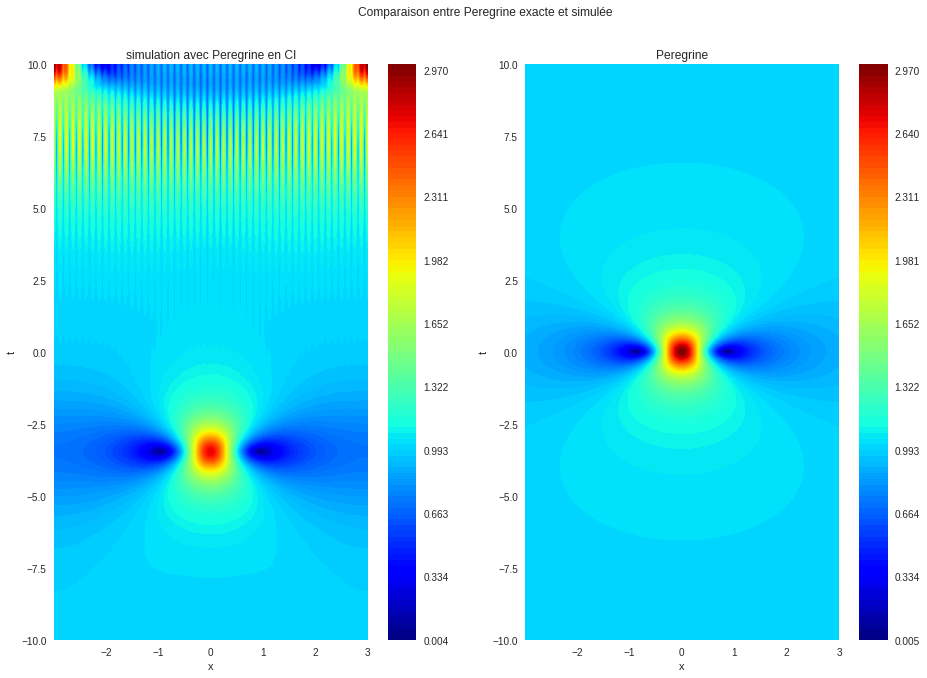

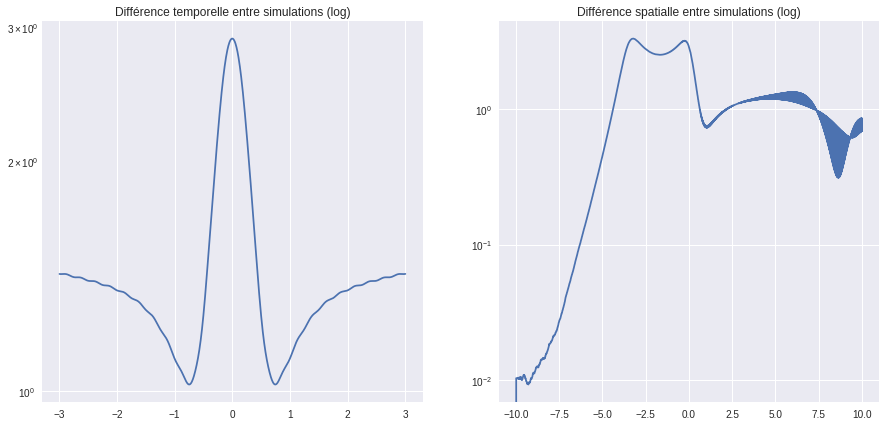

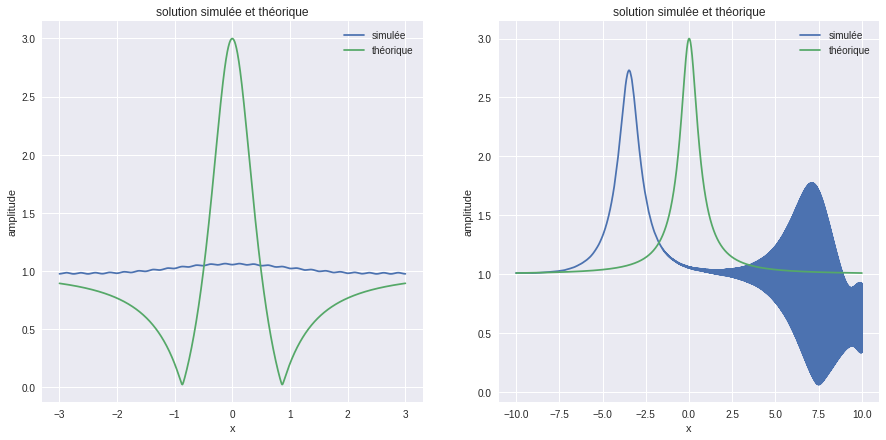

In [46]:
peregrine(6)

Nous remarquons que pour un petit domaine ($L=6$), le maximum est décalé dans la solution exacte: Il ne strouve pas en $t=0$, comme dans la solution simulée. De plus nous observons des effets de bord dans la solution exacte qui sont absents dans la simulée. Cependant, nous observons que la simulée est fort instable lorsque x croît.

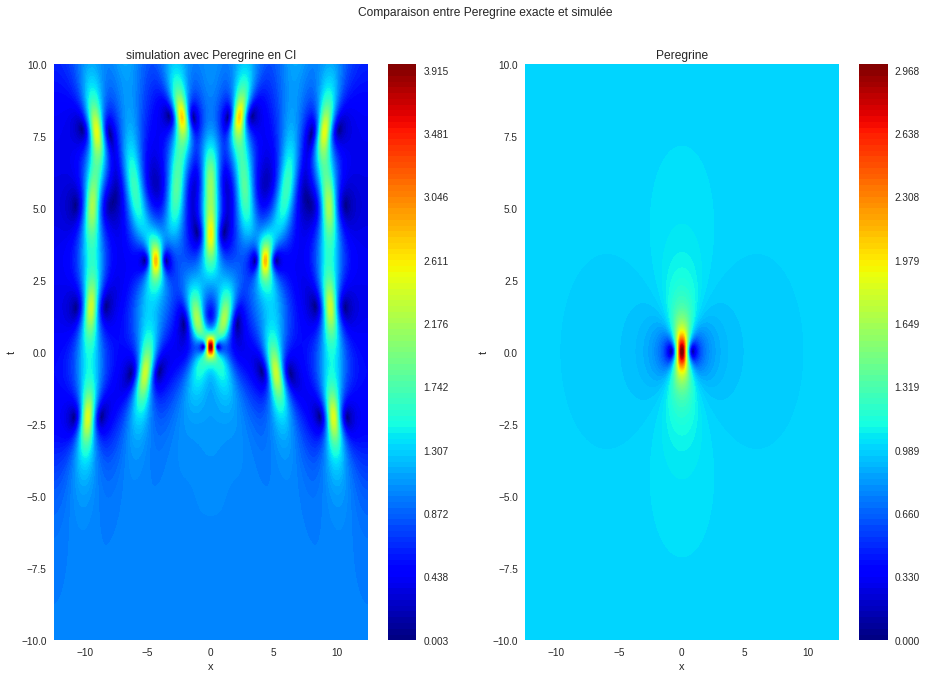

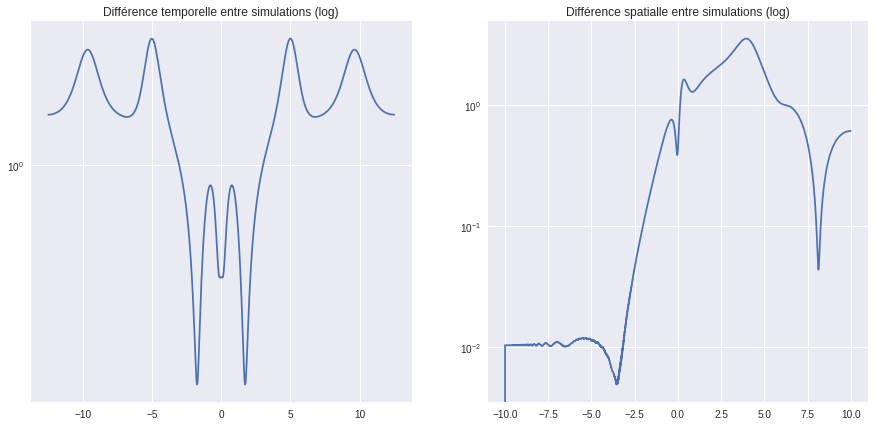

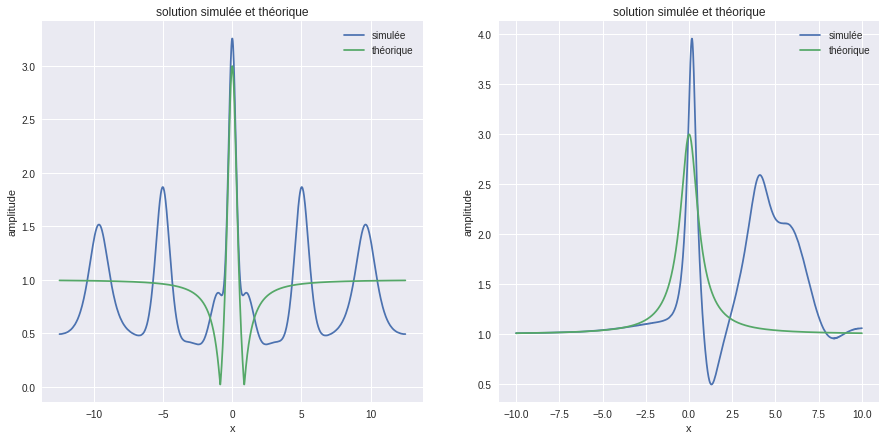

In [47]:
peregrine(25)

Dans ce domaine ($L= 25$), nous voyons (dans le dernier graphe) que les solutions se raprochent plus. Cependant, or le maximum se trouve au même endroit que dans la simulée, nous observons qu'il y a des maxima qui se forment aux alentours de ce maximum central. 

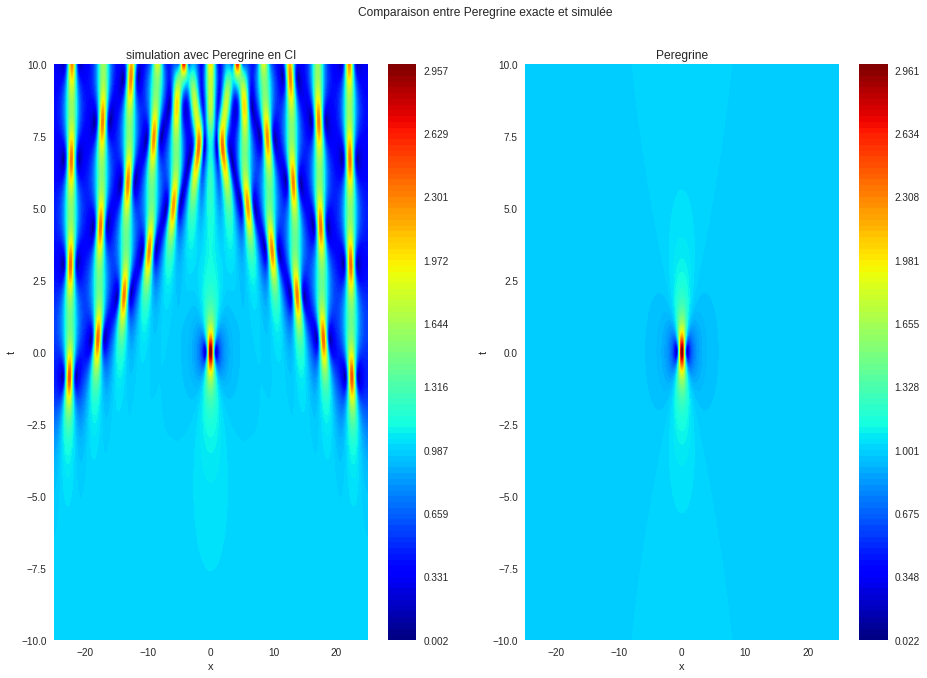

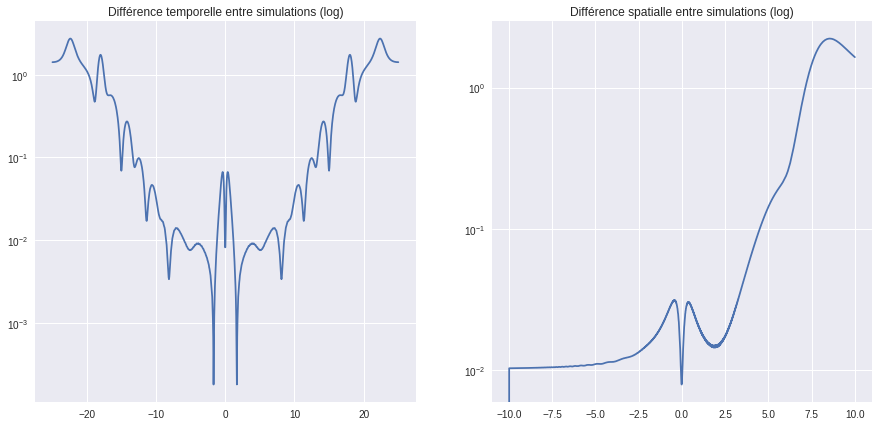

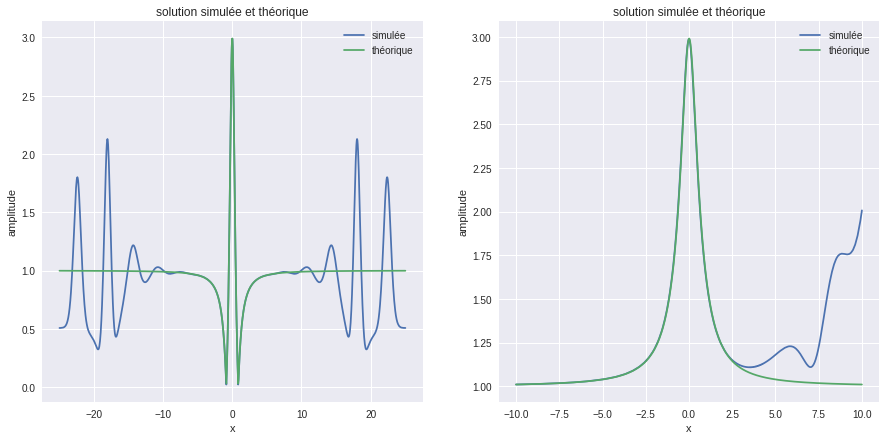

In [48]:
peregrine(50)

Dans ce domaine ($L=50$), nous pouvons observer (dans les graphes du bas) que les solutions se ressemblent beaucoup plus maintenant, au moins autour du maximum, qui est au même endroit que dans la simulée. Nous observons également que l'instabilité trouvée dans les graphes précédents est en train de disparaître, même si elle est encore assez présente aux bords.

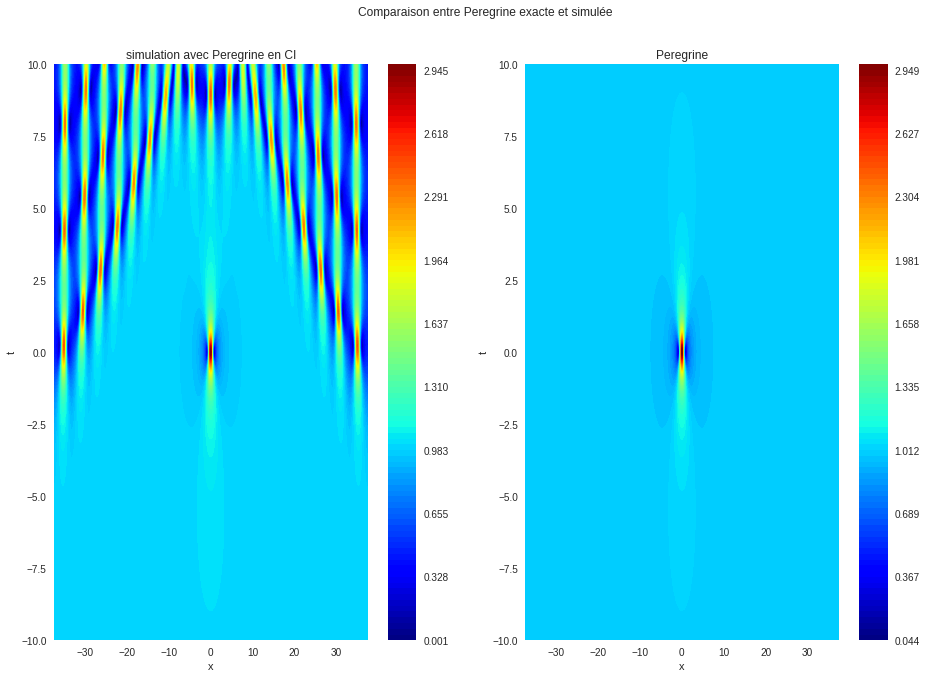

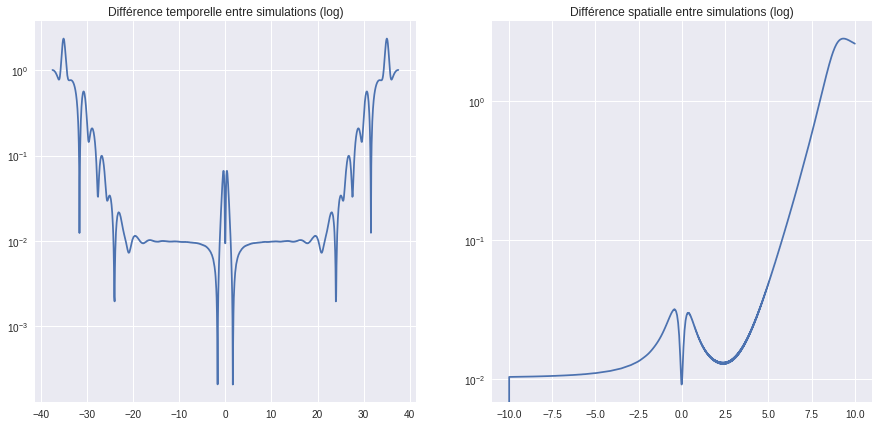

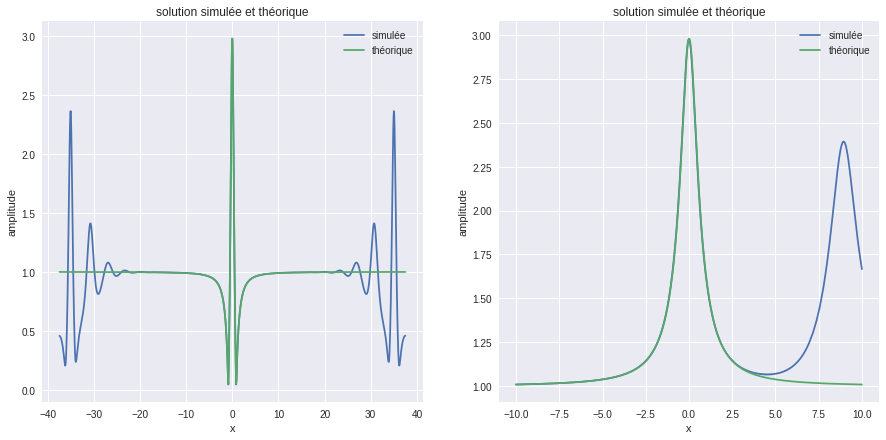

In [49]:
peregrine(75)

Dans ce domaine ($L=75$), nous constatons tout de même, les même choses que dans le domaine précédent mais plus précises, malgré le fait que les maxima aux bords semblent avoir devenu plus grands.

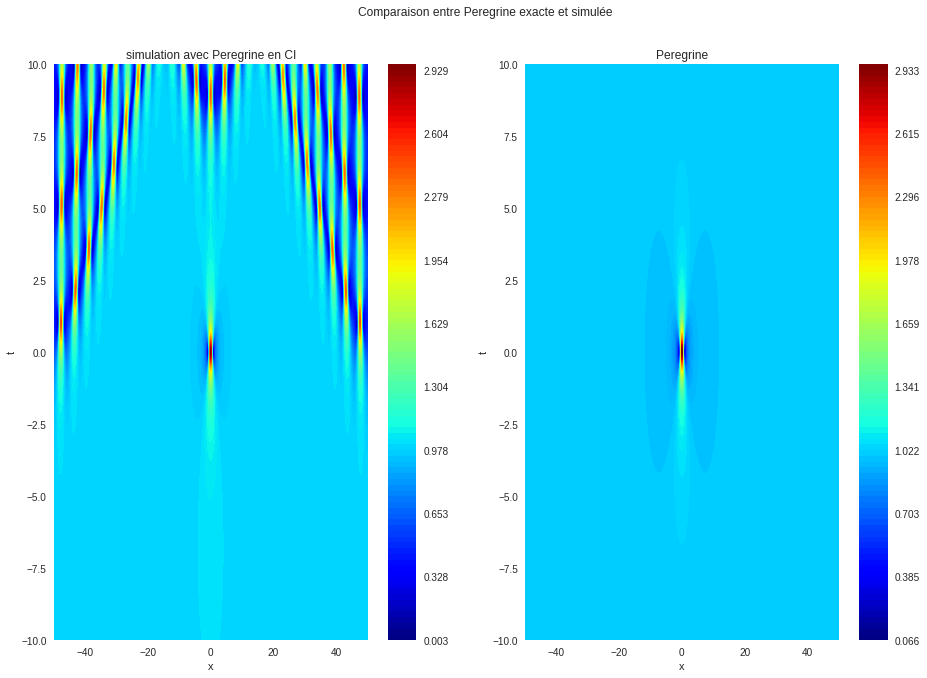

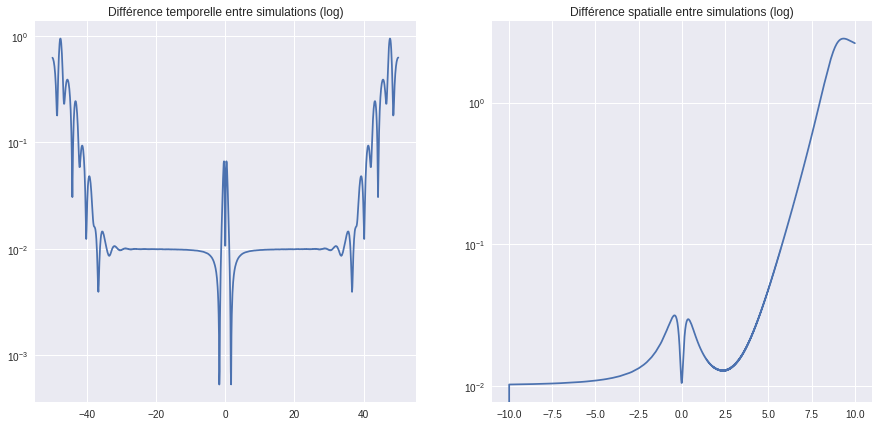

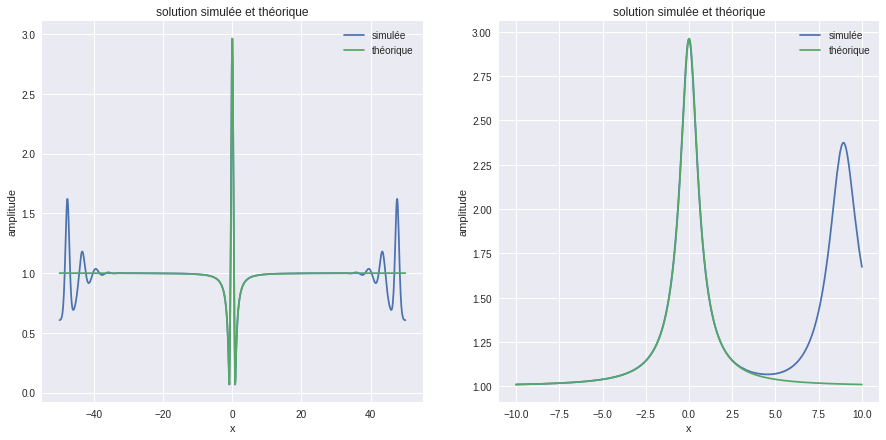

In [50]:
peregrine(100)

Dans ce domaine ($L=100$), nous constatons que les conditions sont tout de même semblables à celles du domaine précédent. Cependant, Il est évident que les effets de bords perdent leurs intensité et que la solution exacte commence à se ressembler fort à la solution simulée.

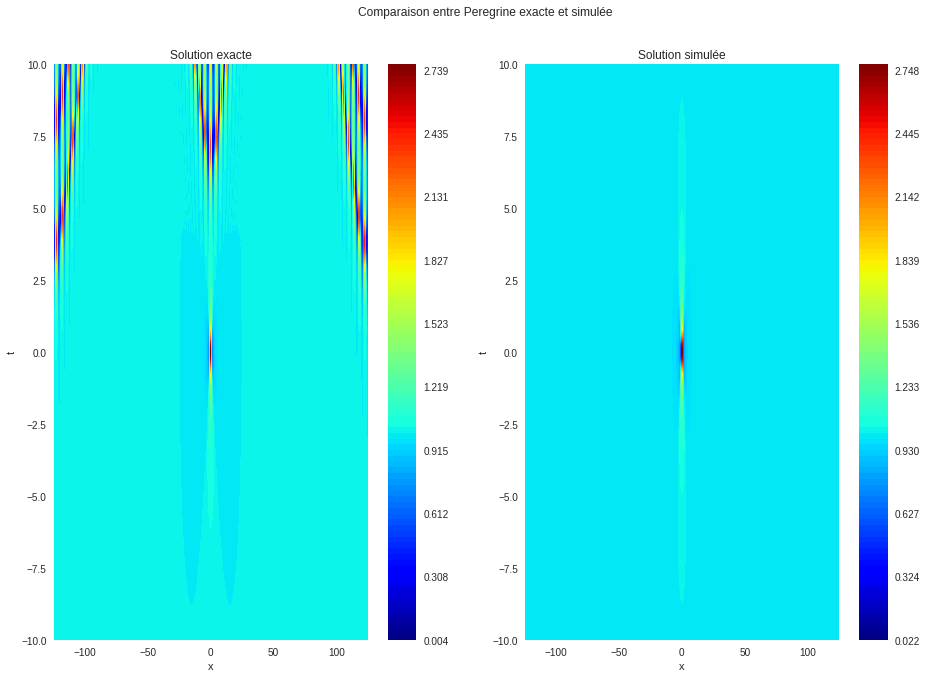

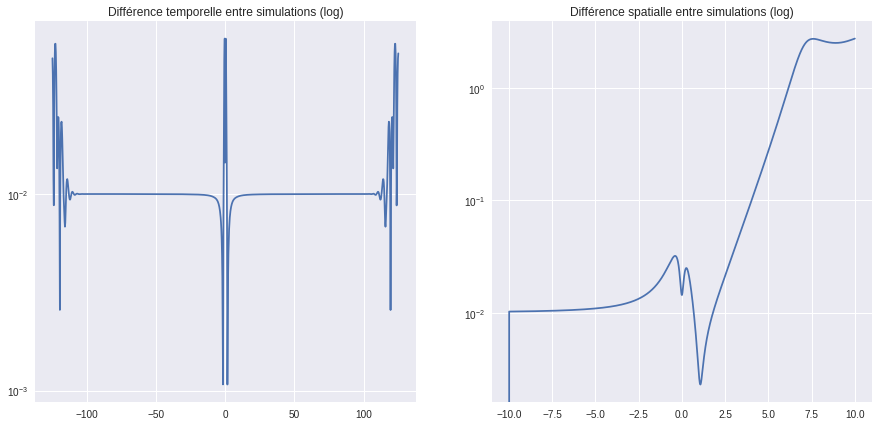

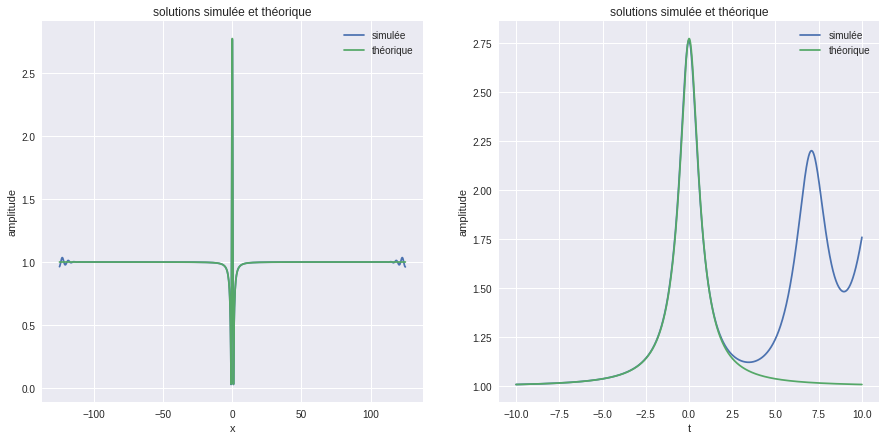

In [8]:
peregrine(250)

Dans ce dernier domaine ($L=250$), nous voyons clairement la ressemblance entre les solutions. Les seules différences se trouvent aux bords de l'exacte, ou nous observons des petits pics accumulés et une forte instabilité temporelle. En outre, comparant aux graphes des domaines précédents, nous observons que ces effets de bords s'éloignent de plus en plus. 

Nous remarquons donc, que la solution exacte ressemble la solution simulée de plus en plus lorsque la taille du domaine devient plus grande. Nous pouvons donc dire que la solution exacte tend vers la solution simulée lorsque la taille du domaine $L$ devient très grand, ergo lorsque $L$ devient non-borné.